<a href="https://colab.research.google.com/github/ThienNguyen3001/Stock-Price-Prediction-RNN-LSTM-GRU/blob/main/stock_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

In [1]:
%%capture
!git clone https://github.com/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN.git

In [2]:
import os
if not os.getcwd().endswith('Stock-Price-Prediction-LSTM-RNN'):
    %cd Stock-Price-Prediction-LSTM-RNN

/content/Stock-Price-Prediction-LSTM-RNN


In [3]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
torch.manual_seed(38)

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


# Thêm data

In [4]:
df = pd.read_csv(r'/content/Stock-Price-Prediction-LSTM-RNN/data/EBAY.csv')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1998-09-24 00:00:00-04:00,0.869536,0.881727,0.719196,0.769987,518656090,0.0,0.0
1,1998-09-25 00:00:00-04:00,0.739513,0.749671,0.668406,0.729354,121255834,0.0,0.0
2,1998-09-28 00:00:00-04:00,0.772019,0.826872,0.747639,0.784208,89772883,0.0,0.0
3,1998-09-29 00:00:00-04:00,0.802492,0.816714,0.776082,0.794366,39289536,0.0,0.0
4,1998-09-30 00:00:00-04:00,0.766939,0.780145,0.702944,0.732401,44113766,0.0,0.0
...,...,...,...,...,...,...,...,...
6284,2023-09-15 00:00:00-04:00,44.459999,44.799999,44.270000,44.560001,7598200,0.0,0.0
6285,2023-09-18 00:00:00-04:00,44.340000,44.459999,43.810001,43.910000,4580500,0.0,0.0
6286,2023-09-19 00:00:00-04:00,43.630001,44.090000,43.419998,43.619999,4308500,0.0,0.0
6287,2023-09-20 00:00:00-04:00,43.740002,44.540001,43.669998,43.689999,4127600,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6289 entries, 0 to 6288
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6289 non-null   object 
 1   Open          6289 non-null   float64
 2   High          6289 non-null   float64
 3   Low           6289 non-null   float64
 4   Close         6289 non-null   float64
 5   Volume        6289 non-null   int64  
 6   Dividends     6289 non-null   float64
 7   Stock Splits  6289 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 393.2+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6289.000000,6289.000000,6289.000000,6289.000000,6.289000e+03,6289.000000,6289.000000
mean,20.987507,21.274195,20.712163,20.993187,3.368776e+07,0.000564,0.001809
std,15.471087,15.648770,15.306095,15.473983,3.370100e+07,0.010472,0.065071
min,0.453053,0.475401,0.410389,0.471338,1.574977e+06,0.000000,0.000000
25%,9.291526,9.467058,9.166702,9.311030,1.088010e+07,0.000000,0.000000
50%,15.610702,15.875948,15.419567,15.622402,2.701726e+07,0.000000,0.000000
75%,30.316031,30.705290,30.010181,30.353100,4.423209e+07,0.000000,0.000000
max,77.933596,78.145354,76.903719,77.567848,5.776987e+08,0.250000,3.000000


# Làm sạch dữ liệu

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-7-b9c6864122be>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [8]:
df.set_index('Date', inplace = True)

In [9]:
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

# Trực quan hóa dữ liệu

## Time series

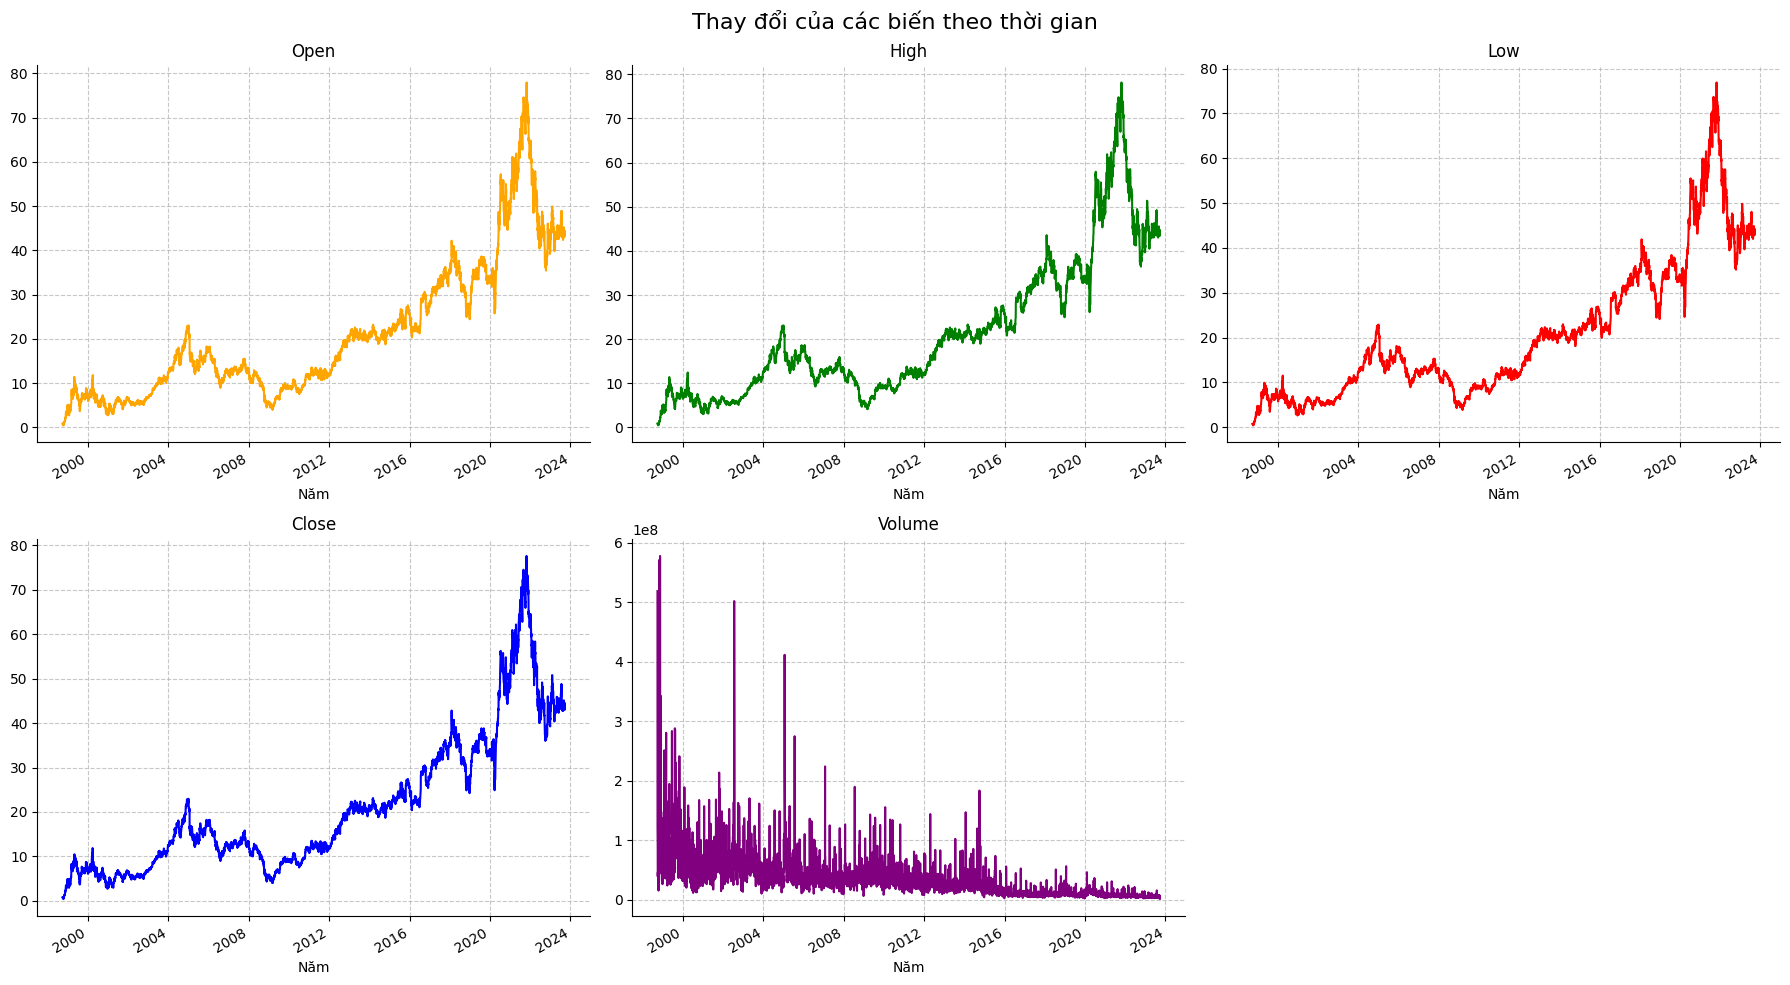

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Thay đổi của các biến theo thời gian', fontsize=16)

metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Volume', 'purple', 'Volume')
}

for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

* Tất cả các biểu đồ ngoại trừ "Volume" đều có một dạng tương tự và đó là bởi vì sau giá mở cửa, thị trường chứng khoán thường có một biến động nhỏ lên xuống khiến cho các biểu đồ giá này tuân theo cùng một mô hình nhưng đối với cột "Volume" thì đây là một quá trình khá ngẫu nhiên đối với lượng giao dịch trong một ngày nhất định.

## Box plot

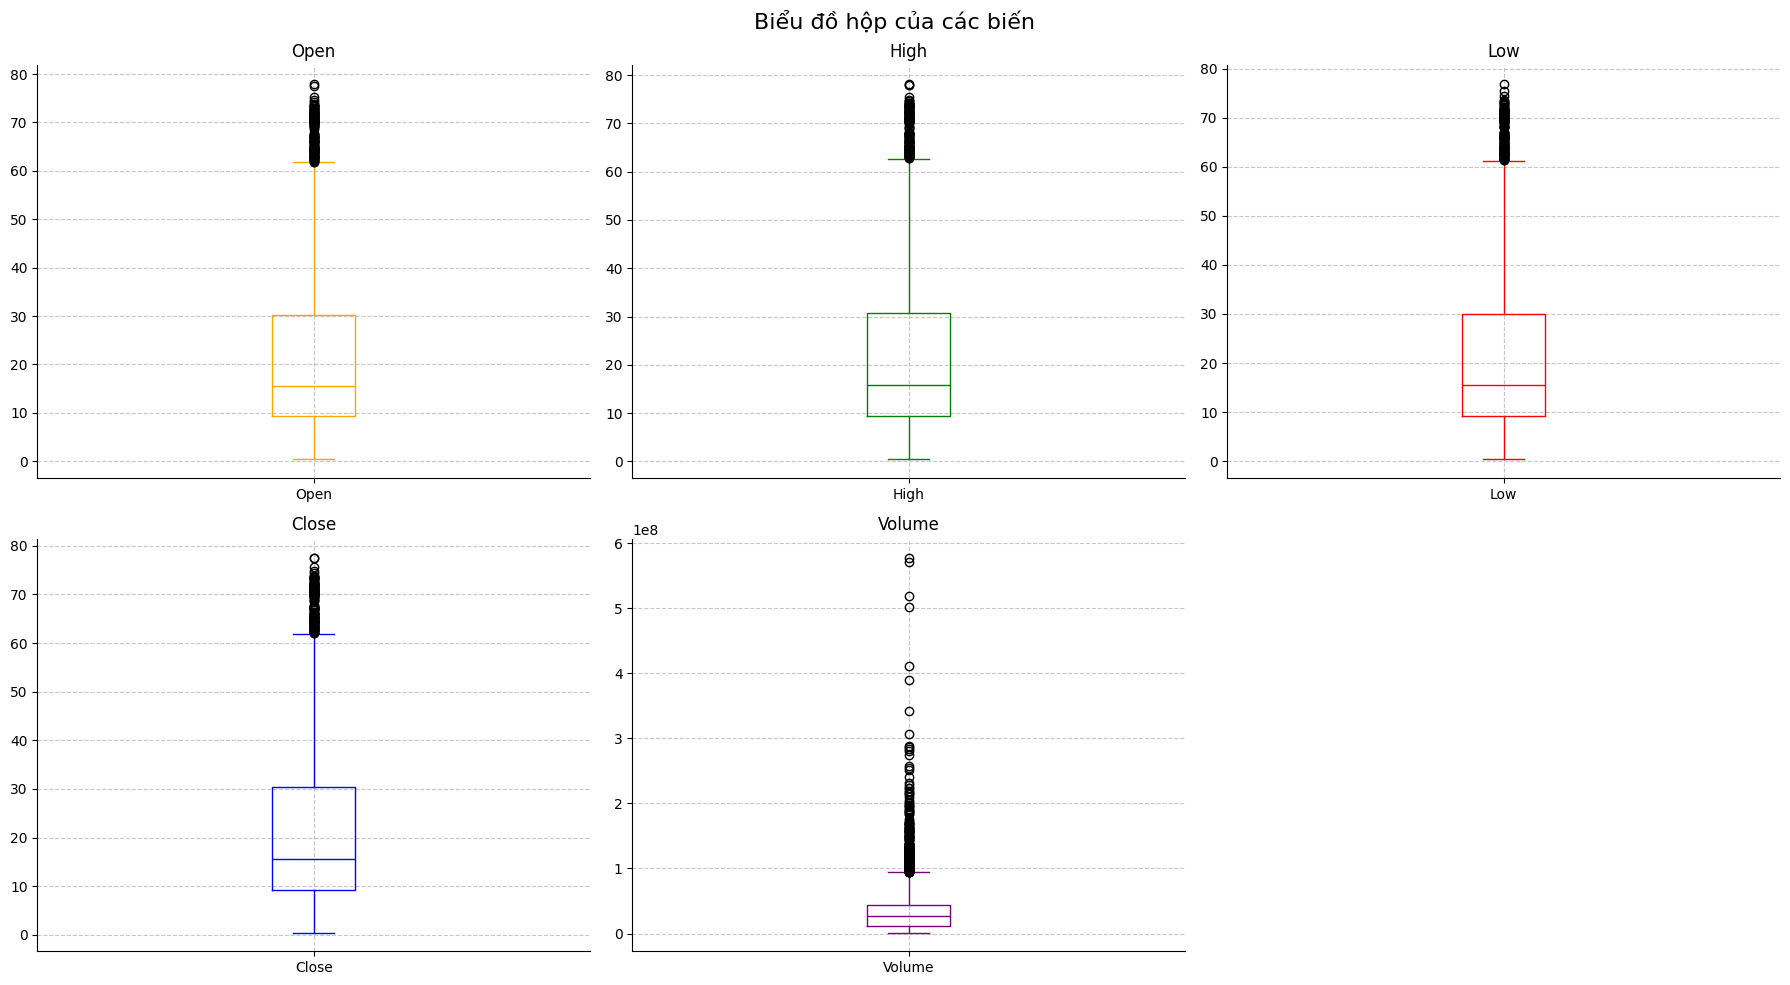

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Biểu đồ hộp của các biến', fontsize=16)

metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Volume', 'purple', 'Volume')
}

for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot.box(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

* Đối với các biến về giá, có thể nhận thấy rằng nhìn chung chúng được phân bổ tốt nhưng biến "Volume" chứa một số giá trị ngoại lệ. Điều này được giải thích bởi thực tế là khi cổ phiếu giao dịch bắt đầu tăng thì giá trị giá giảm xuống, giải thích cho sự sụt giảm đột ngột về giá và "Volume" đạt đỉnh.

## Tỷ lệ tăng trưởng

* Tỷ lệ tăng trưởng là phần trăm thay đổi của một giá trị trong một khoảng thời gian cụ thể. Công thức tính là:
$
\text{Growth Rate} = \frac{\text{New Value} - \text{Old Value}}{\text{Old Value}} \times 100\%
$

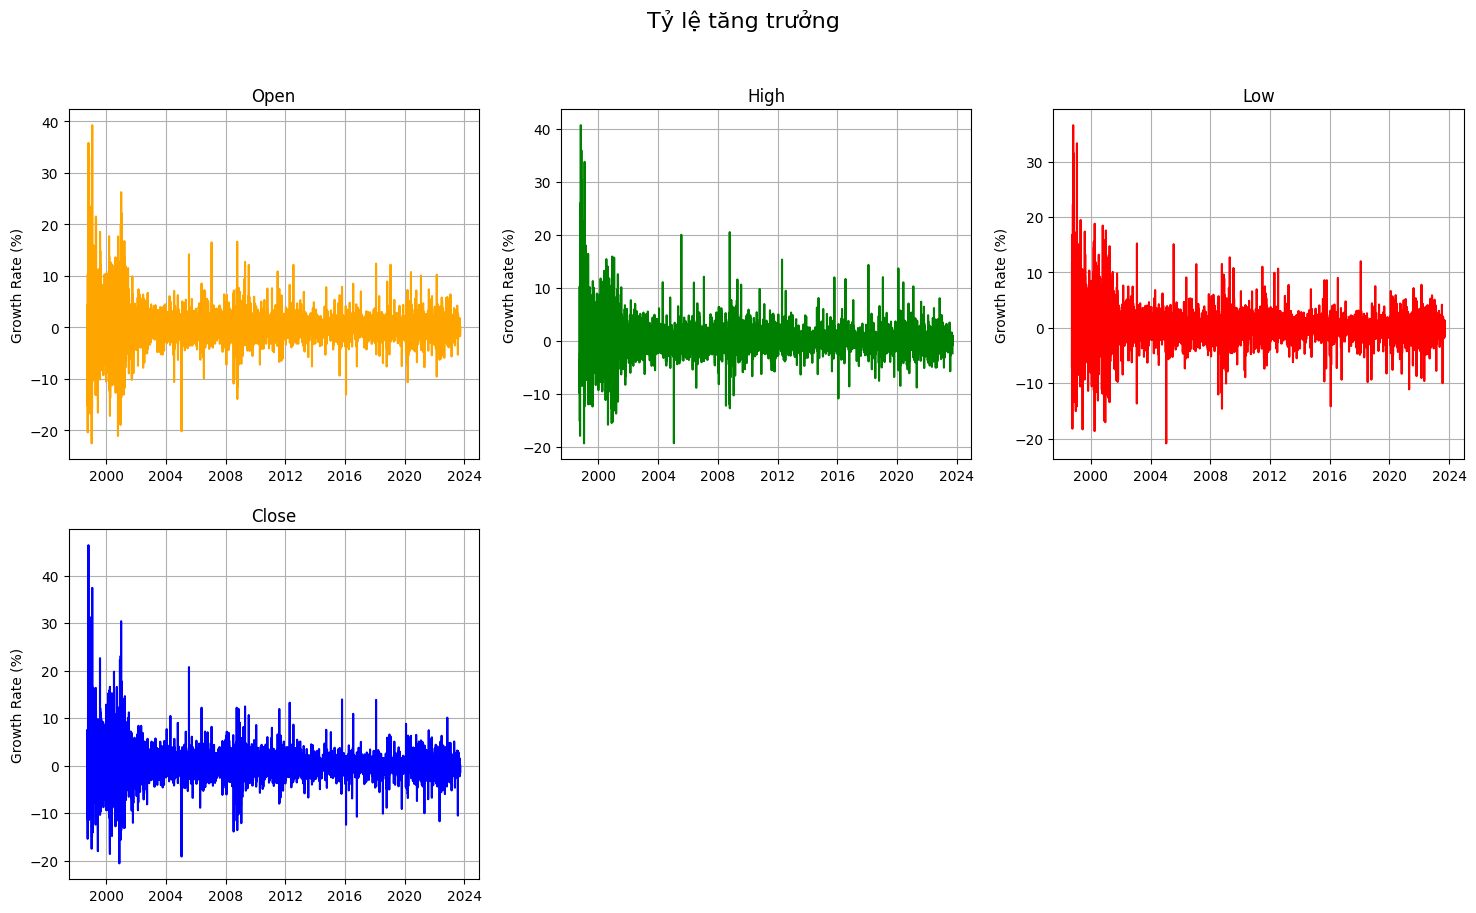

In [12]:
plt.figure(figsize=(18,10))
plt.suptitle("Tỷ lệ tăng trưởng", fontsize=16)
i=1
colors = ['orange', 'green', 'red', 'blue', 'brown', 'purple']
for x, color in zip(df.columns[:-1], colors):
    plt.subplot(2,3,i)
    df['Growth Rate'] = (df[x] - df[x].shift(1)) / df[x].shift(1) * 100
    plt.plot(df.index, df['Growth Rate'], linestyle='-', color=color)
    plt.xlabel(None)
    plt.ylabel('Growth Rate (%)')
    plt.title(f'{x}')
    plt.grid(True)
    i+=1
plt.show()

* Ở các biến giá thì tỷ lệ tăng trưởng biến động khá cao ở khoảng độ giữa năm 2020 và 2021, đỉnh điểm của dịch Covid-19

## Ma trận tương quan

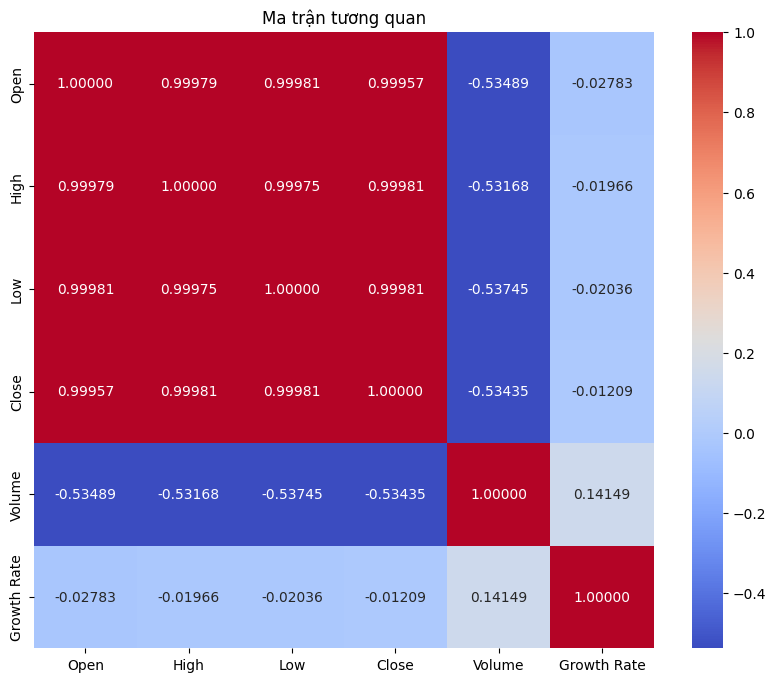

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".5f")
plt.title('Ma trận tương quan')
plt.show()

* Ma trận này thể hiện mối liên hệ rất tuyến tính mạnh giữa các giá trị về giá (High, Low, Open, Close, Adj Close).
* "Volume" có mối tương quan âm với các biến giá, nghĩa là khi "Volume" tăng, các giá trị về giá có xu hướng giảm nhẹ, nhưng mối quan hệ này không quá mạnh.

# Chuẩn bị dữ liệu

In [14]:
closing_price = df[['Close']]

window_size = 15 #14 input values and 15th value is the target

In [15]:
from src.split_data import split_data
#Preparing inputs
scaler,X_train, y_train, X_test, y_test = split_data(closing_price, window_size)

In [16]:
#Converting data to tensors for the model
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_rnn = y_train_lstm = y_train_gru = y_train_ann =torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = y_test_lstm = y_test_gru = y_test_ann = torch.from_numpy(y_test).type(torch.Tensor)

# Chạy mô hình RNN

In [17]:
from src.rnn import RNN

In [18]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
rnn_model = RNN(num_input, num_hidden, num_layer, num_output)

In [19]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.01
rnn_criterion = nn.MSELoss(reduction = 'mean')
rnn_updater = torch.optim.Adam(rnn_model.parameters(), lr = lr)

In [20]:
#Training RNN model
train_hist_rnn = np.zeros(num_epochs)
val_hist_rnn = np.zeros(num_epochs)
for epoch in range(num_epochs):
    y_train_pred_rnn = rnn_model(X_train)
    loss = rnn_criterion(y_train_pred_rnn, y_train_rnn)
    train_hist_rnn[epoch] = loss.item()
    with torch.no_grad():
        y_val_pred_rnn = rnn_model(X_test)
        val_loss = rnn_criterion(y_val_pred_rnn, y_test_rnn)
        val_hist_rnn[epoch] = val_loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    rnn_updater.zero_grad()
    loss.backward()
    rnn_updater.step()

Epoch  0 MSE:  0.4029700756072998
Epoch  5 MSE:  0.18184944987297058
Epoch  10 MSE:  0.1257871389389038
Epoch  15 MSE:  0.09758365899324417
Epoch  20 MSE:  0.060398343950510025
Epoch  25 MSE:  0.041536130011081696
Epoch  30 MSE:  0.021046433597803116
Epoch  35 MSE:  0.015165233984589577
Epoch  40 MSE:  0.012005110271275043
Epoch  45 MSE:  0.012713943608105183
Epoch  50 MSE:  0.011036613024771214
Epoch  55 MSE:  0.008957471698522568
Epoch  60 MSE:  0.0077101243659853935
Epoch  65 MSE:  0.006938480772078037
Epoch  70 MSE:  0.006480630952864885
Epoch  75 MSE:  0.005920250900089741
Epoch  80 MSE:  0.005336542148143053
Epoch  85 MSE:  0.004886873532086611
Epoch  90 MSE:  0.004528348334133625
Epoch  95 MSE:  0.004201957955956459


Text(0, 0.5, 'Loss')

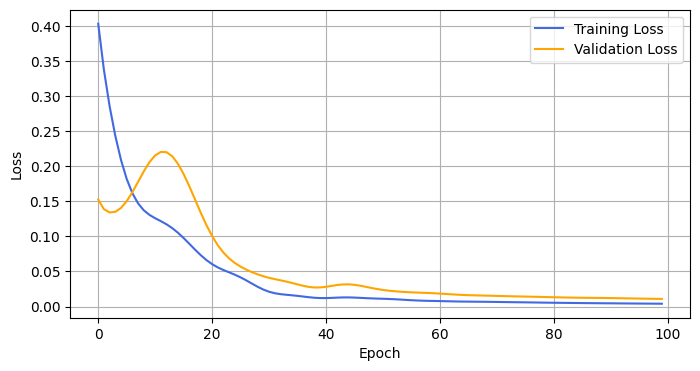

In [21]:
#Training loss for RNN model
rcParams['figure.figsize'] = 8,4
sns.lineplot(data = train_hist_rnn, color = 'royalblue', label = 'Training Loss')
sns.lineplot(data = val_hist_rnn, color = 'orange', label = 'Validation Loss')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title("RNN model loss")

# Chạy mô hình LSTM

In [22]:
from src.lstm import LSTM

In [23]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
lstm_model = LSTM(num_input, num_hidden, num_layer, num_output)

In [24]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.01
lstm_criterion = nn.MSELoss(reduction = 'mean')
lstm_updater = torch.optim.Adam(lstm_model.parameters(), lr = lr)

In [25]:
#Training LSTM model
train_hist_lstm = np.zeros(num_epochs)
val_hist_lstm = np.zeros(num_epochs)
for epoch in range(num_epochs):
    y_train_pred_lstm = lstm_model(X_train)
    loss = lstm_criterion(y_train_pred_lstm, y_train_lstm)
    train_hist_lstm[epoch] = loss.item()
    with torch.no_grad():
        y_val_pred_lstm = lstm_model(X_test)
        val_loss = lstm_criterion(y_val_pred_lstm, y_test_lstm)
        val_hist_lstm[epoch] = val_loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    lstm_updater.zero_grad()
    loss.backward()
    lstm_updater.step()

Epoch  0 MSE:  0.17040972411632538
Epoch  5 MSE:  0.13358110189437866
Epoch  10 MSE:  0.09663315862417221
Epoch  15 MSE:  0.06018916517496109
Epoch  20 MSE:  0.03295823559165001
Epoch  25 MSE:  0.022863926365971565
Epoch  30 MSE:  0.02360183745622635
Epoch  35 MSE:  0.021234331652522087
Epoch  40 MSE:  0.014344017021358013
Epoch  45 MSE:  0.01166312675923109
Epoch  50 MSE:  0.008618590421974659
Epoch  55 MSE:  0.006279257126152515
Epoch  60 MSE:  0.004727065563201904
Epoch  65 MSE:  0.0031621684320271015
Epoch  70 MSE:  0.002346667693927884
Epoch  75 MSE:  0.0017238673754036427
Epoch  80 MSE:  0.0014013656182214618
Epoch  85 MSE:  0.0011182150337845087
Epoch  90 MSE:  0.0009504416375420988
Epoch  95 MSE:  0.0008266826043836772


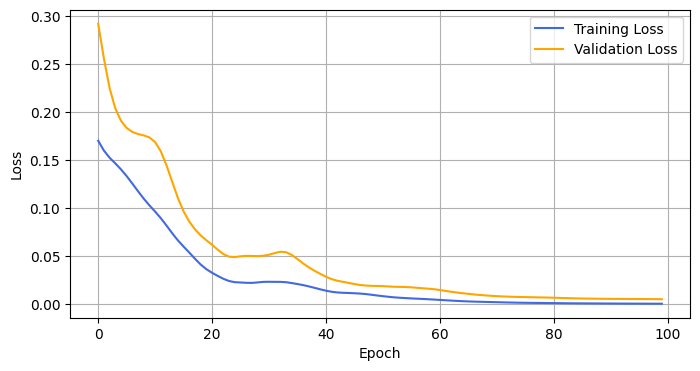

In [26]:
#Training loss for LSTM model
rcParams['figure.figsize'] = 8,4
sns.lineplot(data = train_hist_lstm, color = 'royalblue', label='Training Loss')
sns.lineplot(data = val_hist_lstm, color = 'orange', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
# plt.title("LSTM training loss")
plt.legend() # Show the legend
plt.show()

In [27]:
from src.gru import GRU
gru_model = GRU(num_input, num_hidden, num_layer, num_output)

In [28]:
num_epochs, lr = 100, 0.01
gru_criterion = nn.MSELoss(reduction = 'mean')
gru_updater = torch.optim.Adam(gru_model.parameters(), lr = lr)

In [29]:
#Training GRU model
train_hist_gru = np.zeros(num_epochs)
val_hist_gru = np.zeros(num_epochs)
for epoch in range(num_epochs):
    y_train_pred_gru = gru_model(X_train)
    loss = gru_criterion(y_train_pred_gru, y_train_gru)
    train_hist_gru[epoch] = loss.item()
    with torch.no_grad():
        y_val_pred_gru = gru_model(X_test)
        val_loss = gru_criterion(y_val_pred_gru, y_test_gru)
        val_hist_gru[epoch] = val_loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    gru_updater.zero_grad()
    loss.backward()
    gru_updater.step()

Epoch  0 MSE:  0.1532583236694336
Epoch  5 MSE:  0.09898388385772705
Epoch  10 MSE:  0.0514691025018692
Epoch  15 MSE:  0.012923340313136578
Epoch  20 MSE:  0.002661626087501645
Epoch  25 MSE:  0.008655399084091187
Epoch  30 MSE:  0.0007723129238002002
Epoch  35 MSE:  0.002171118278056383
Epoch  40 MSE:  0.002160413656383753
Epoch  45 MSE:  0.0005927394377067685
Epoch  50 MSE:  0.0009201226057484746
Epoch  55 MSE:  0.0007955579203553498
Epoch  60 MSE:  0.0005173428216949105
Epoch  65 MSE:  0.0006330332835204899
Epoch  70 MSE:  0.000524432398378849
Epoch  75 MSE:  0.0005062316195107996
Epoch  80 MSE:  0.0005088985781185329
Epoch  85 MSE:  0.0004757463466376066
Epoch  90 MSE:  0.0004794486449100077
Epoch  95 MSE:  0.00046471779933199286


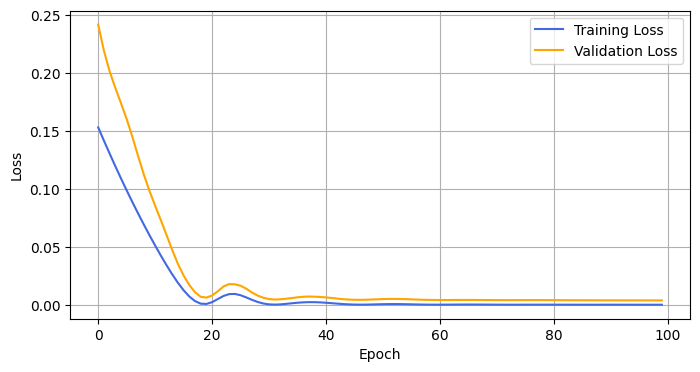

In [30]:
#Training loss for GRU model
rcParams['figure.figsize'] = 8,4
sns.lineplot(data = train_hist_gru, color = 'royalblue', label = 'Training Loss')
sns.lineplot(data = val_hist_gru, color = 'orange', label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
# plt.title("GRU model loss")

In [31]:
!sudo apt update
!sudo apt install ttf-mscorefonts-installer

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,741 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,003 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu

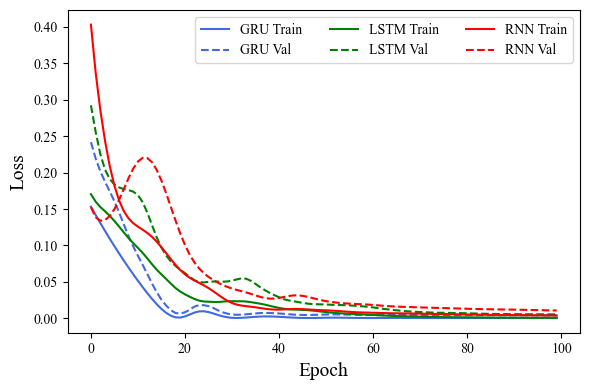

In [32]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
rcParams['figure.figsize'] = 6, 4
# Cấu hình font Times New Roman
times_new_roman = font_manager.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')

# Vẽ các đường loss
sns.lineplot(data=train_hist_gru, color='royalblue', label='GRU Train')
sns.lineplot(data=val_hist_gru, color='royalblue', label='GRU Val', linestyle='--')
sns.lineplot(data=train_hist_lstm, color='green', label='LSTM Train')
sns.lineplot(data=val_hist_lstm, color='green', label='LSTM Val', linestyle='--')
sns.lineplot(data=train_hist_rnn, color='red', label='RNN Train')
sns.lineplot(data=val_hist_rnn, color='red', label='RNN Val', linestyle='--')

# Nhãn trục
plt.xlabel("Epoch", fontproperties=times_new_roman, fontsize=14)
plt.ylabel("Loss", fontproperties=times_new_roman, fontsize=14)

# Cập nhật font cho các tick labels
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontproperties(times_new_roman)

# Tạo legend theo ma trận 2 dòng 3 cột
plt.legend(
    prop=times_new_roman,
    loc="upper right",  # Đặt legend ở phía trên
    ncol=3,  # 2 dòng, 3 cột
    fontsize=12
)

# Đảm bảo layout không bị cắt
plt.tight_layout()
plt.savefig('loss.svg', format='svg')
plt.show()


# Test hiệu năng

## RNN

In [33]:
#RNN model performance on testing data
rnn_model.eval()
y_test_pred_rnn = rnn_model(X_test)

In [34]:
#Converting the data back to its original form
rnn_train_pred = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
rnn_train_orig = scaler.inverse_transform(y_train_rnn.detach().numpy())
rnn_test_pred = scaler.inverse_transform(y_test_pred_rnn.detach().numpy())
rnn_test_orig = scaler.inverse_transform(y_test_rnn.detach().numpy())

In [35]:
from src.calculate_metrics import calculate_metrics
train_rnn_rmse, train_rnn_mse, train_rnn_mae, train_rnn_mape, train_rnn_r2 = calculate_metrics(rnn_train_orig[:, 0], rnn_train_pred[:, 0])

# Calculate metrics for testing data
test_rnn_rmse, test_rnn_mse, test_rnn_mae, test_rnn_mape, test_rnn_r2 = calculate_metrics(rnn_test_orig[:, 0], rnn_test_pred[:, 0])

# Print the metrics
print('Train:')
print(f'RMSE: {train_rnn_rmse:.4f}')
print(f'MSE: {train_rnn_mse:.4f}')
print(f'MAE: {train_rnn_mae:.4f}')
print(f'MAPE: {train_rnn_mape:.4f}')
print(f'R2: {train_rnn_r2:.4f}')

print('\nTest:')
print(f'RMSE: {test_rnn_rmse:.4f}')
print(f'MSE: {test_rnn_mse:.4f}')
print(f'MAE: {test_rnn_mae:.4f}')
print(f'MAPE: {test_rnn_mape:.4f}')
print(f'R2: {test_rnn_r2:.4f}')

Train:
RMSE: 0.3585
MSE: 0.1285
MAE: 0.2768
MAPE: 0.0828
R2: 0.9758

Test:
RMSE: 0.5900
MSE: 0.3481
MAE: 0.4434
MAPE: 0.0779
R2: 0.9146


In [36]:
#Preparing predictions for the plot comparisons for RNN model
rnn_train_data = np.append(rnn_train_orig, rnn_train_pred, axis = 1)
rnn_test_data = np.append(rnn_test_orig, rnn_test_pred, axis = 1)

rnn_train_plot = pd.DataFrame(rnn_train_data)
rnn_train_plot.columns = ['Actual', 'Predicted']
rnn_test_plot = pd.DataFrame(rnn_test_data)
rnn_test_plot.columns = ['Actual', ' Predicted']

Text(0, 0.5, 'Closing')

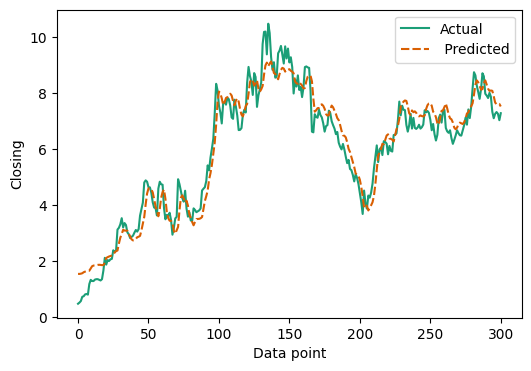

In [37]:
#Predictions vs actual price for the RNN model
sns.set_palette('Dark2')

# fig, axes = plt.subplots(1, 1, sharex = False, figsize = (13,6))
# fig.suptitle('Actual vs predicted prices for all models')

# rnn_training_plot = sns.lineplot(ax = axes[0], data = rnn_train_plot)
# rnn_training_plot.set_title('RNN (training)')
# rnn_training_plot.set_xlabel('Data point')
# rnn_training_plot.set_ylabel('Closing')

rnn_testing_plot = sns.lineplot(data = rnn_test_plot[0:301])
# rnn_testing_plot.set_title('RNN (testing)')
rnn_testing_plot.set_xlabel('Data point')
rnn_testing_plot.set_ylabel('Closing')

## GRU

In [38]:
gru_model.eval()
y_test_pred_gru = gru_model(X_test)

In [39]:
#Converting the data back to its original form
gru_train_pred = scaler.inverse_transform(y_train_pred_gru.detach().numpy())
gru_train_orig = scaler.inverse_transform(y_train_gru.detach().numpy())
gru_test_pred = scaler.inverse_transform(y_test_pred_gru.detach().numpy())
gru_test_orig = scaler.inverse_transform(y_test_gru.detach().numpy())

In [40]:
from src.calculate_metrics import calculate_metrics
train_gru_rmse, train_gru_mse, train_gru_mae, train_gru_mape, train_gru_r2 = calculate_metrics(gru_train_orig[:, 0], gru_train_pred[:, 0])
test_gru_rmse, test_gru_mse, test_gru_mae, test_gru_mape, test_gru_r2 = calculate_metrics(gru_test_orig[:, 0], gru_test_pred[:, 0])

print('Train:')
print(f'RMSE: {train_gru_rmse:.4f}')
print(f'MSE: {train_gru_mse:.4f}')
print(f'MAE: {train_gru_mae:.4f}')
print(f'MAPE: {train_gru_mape:.4f}')
print(f'R2: {train_gru_r2:.4f}')

print('\nTest:')
print(f'RMSE: {test_gru_rmse:.4f}')
print(f'MSE: {test_gru_mse:.4f}')
print(f'MAE: {test_gru_mae:.4f}')
print(f'MAPE: {test_gru_mape:.4f}')
print(f'R2: {test_gru_r2:.4f}')

Train:
RMSE: 0.1222
MSE: 0.0149
MAE: 0.0870
MAPE: 0.0252
R2: 0.9972

Test:
RMSE: 0.3682
MSE: 0.1355
MAE: 0.2640
MAPE: 0.0461
R2: 0.9667


In [41]:
gru_train_data = np.append(gru_train_orig, gru_train_pred, axis = 1)
gru_test_data = np.append(gru_test_orig, gru_test_pred, axis = 1)

gru_train_plot = pd.DataFrame(gru_train_data)
gru_train_plot.columns = ['Actual', 'Predicted']
gru_test_plot = pd.DataFrame(gru_test_data)
gru_test_plot.columns = ['Actual', ' Predicted']

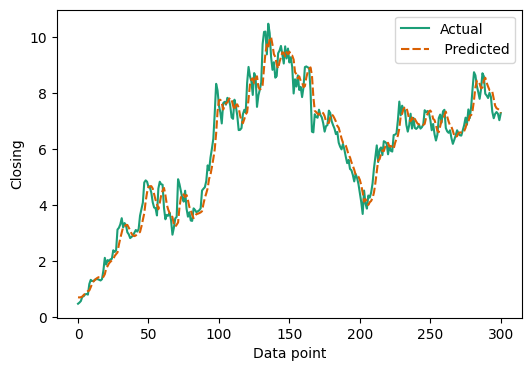

In [42]:
# fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
# fig.suptitle('Actual vs predicted prices for all models')

# gru_training_plot = sns.lineplot(ax = axes[0], data = gru_train_plot)
# gru_training_plot.set_title('GRU (training)')
# gru_training_plot.set_xlabel('Data point')
# gru_training_plot.set_ylabel('Closing')

gru_testing_plot = sns.lineplot(data = gru_test_plot[0:301])
# gru_testing_plot.set_title('GRU (testing)')
gru_testing_plot.set_xlabel('Data point')
gru_testing_plot.set_ylabel('Closing');


## LSTM

In [43]:
#LSTM model performance on testing data
lstm_model.eval()
y_test_pred_lstm = lstm_model(X_test)

In [44]:
#Converting the data back to its original form
lstm_train_pred = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
lstm_train_orig = scaler.inverse_transform(y_train_lstm.detach().numpy())
lstm_test_pred = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
lstm_test_orig = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [45]:
from src.calculate_metrics import calculate_metrics
train_lstm_rmse, train_lstm_mse, train_lstm_mae, train_lstm_mape, train_lstm_r2 = calculate_metrics(lstm_train_orig[:, 0], lstm_train_pred[:, 0])

# Calculate metrics for testing data
test_lstm_rmse, test_lstm_mse, test_lstm_mae, test_lstm_mape, test_lstm_r2 = calculate_metrics(lstm_test_orig[:, 0], lstm_test_pred[:, 0])

# Print the metrics
print('Train:')
print(f'RMSE: {train_lstm_rmse:.4f}')
print(f'MSE: {train_lstm_mse:.4f}')
print(f'MAE: {train_lstm_mae:.4f}')
print(f'MAPE: {train_lstm_mape:.4f}')
print(f'R2: {train_lstm_r2:.4f}')

print('\nTest:')
print(f'RMSE: {test_lstm_rmse:.4f}')
print(f'MSE: {test_lstm_mse:.4f}')
print(f'MAE: {test_lstm_mae:.4f}')
print(f'MAPE: {test_lstm_mape:.4f}')
print(f'R2: {test_lstm_r2:.4f}')

Train:
RMSE: 0.1568
MSE: 0.0246
MAE: 0.1062
MAPE: 0.0312
R2: 0.9954

Test:
RMSE: 0.4191
MSE: 0.1757
MAE: 0.3011
MAPE: 0.0526
R2: 0.9569


In [46]:
#Preparing predictions for the plot comparisons
lstm_train_data = np.append(lstm_train_orig, lstm_train_pred, axis = 1)
lstm_test_data = np.append(lstm_test_orig, lstm_test_pred, axis = 1)

lstm_train_plot = pd.DataFrame(lstm_train_data)
lstm_train_plot.columns = ['Actual', 'Predicted']
lstm_test_plot = pd.DataFrame(lstm_test_data)
lstm_test_plot.columns = ['Actual', ' Predicted']

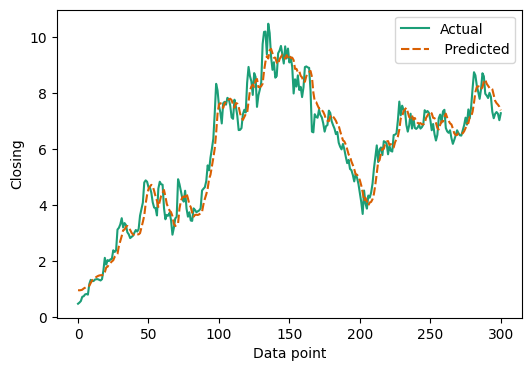

In [47]:
#Prediction vs actual price for LSTM model
sns.set_palette('Dark2')

# fig, axes = plt.subplots(1, 2, sharex = False, figsize = (13,6))
# fig.suptitle('Actual vs predicted prices for all models')

# lstm_training_plot = sns.lineplot(ax = axes[0], data = lstm_train_plot)
# lstm_training_plot.set_title('LSTM (training)')
# lstm_training_plot.set_xlabel('Data point')
# lstm_training_plot.set_ylabel('Closing')

lstm_testing_plot = sns.lineplot(data = lstm_test_plot[0:301])
# lstm_testing_plot.set_title('LSTM (testing)')
lstm_testing_plot.set_xlabel('Data point')
lstm_testing_plot.set_ylabel('Closing');


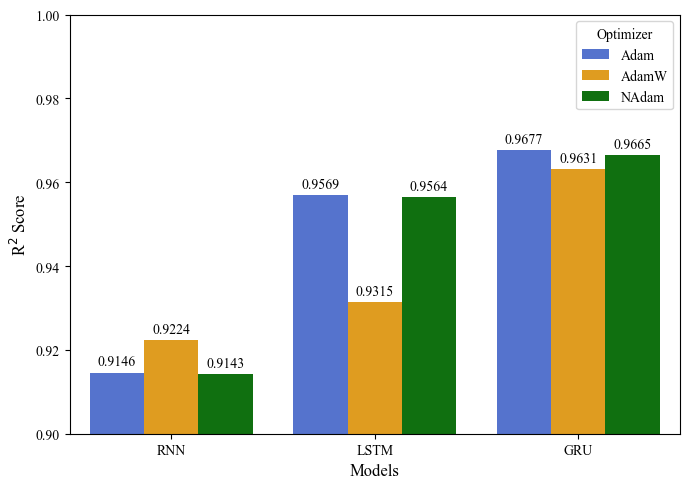

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
rcParams['figure.figsize'] = 4,4
# Load font Times New Roman
times_new_roman = font_manager.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')

# Dữ liệu Accuracy
data = {
    "Model": ["RNN", "RNN", "RNN", "LSTM", "LSTM", "LSTM", "GRU", "GRU", "GRU"],
    "Optimizer": ["Adam", "AdamW", "NAdam"] * 3,
    "R2 Score": [0.9146, 0.9224, 0.9143, 0.9569, 0.9315, 0.9564, 0.9677, 0.9631, 0.9665]
}

# Chuyển thành DataFrame
df = pd.DataFrame(data)

# Vẽ biểu đồ cột ghép với Seaborn
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=df, x="Model", y="R2 Score", hue="Optimizer", palette=["royalblue", "orange", "green"])

# Giới hạn trục Y từ 0.90 đến 1.00
ax.set_ylim(0.90, 1.00)

# Cập nhật nhãn trục X & Y với font Times New Roman
ax.set_xlabel("Models", fontproperties=times_new_roman, fontsize=12)
ax.set_ylabel("R$^2$ Score", fontproperties=times_new_roman, fontsize=12)

# Hiển thị giá trị trên đầu cột
for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", fontsize=10, padding=3, fontproperties=times_new_roman)

# Tạo legend ở góc phải trên với tiêu đề "Optimizer"
ax.legend(title="Optimizer", title_fontproperties=times_new_roman, prop=times_new_roman, loc="upper right")

# Cập nhật font cho các tick labels
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontproperties(times_new_roman)

# Hiển thị đồ thị
plt.tight_layout()
plt.savefig('r2_score.svg',format='svg')
plt.show()


## Tổng hợp

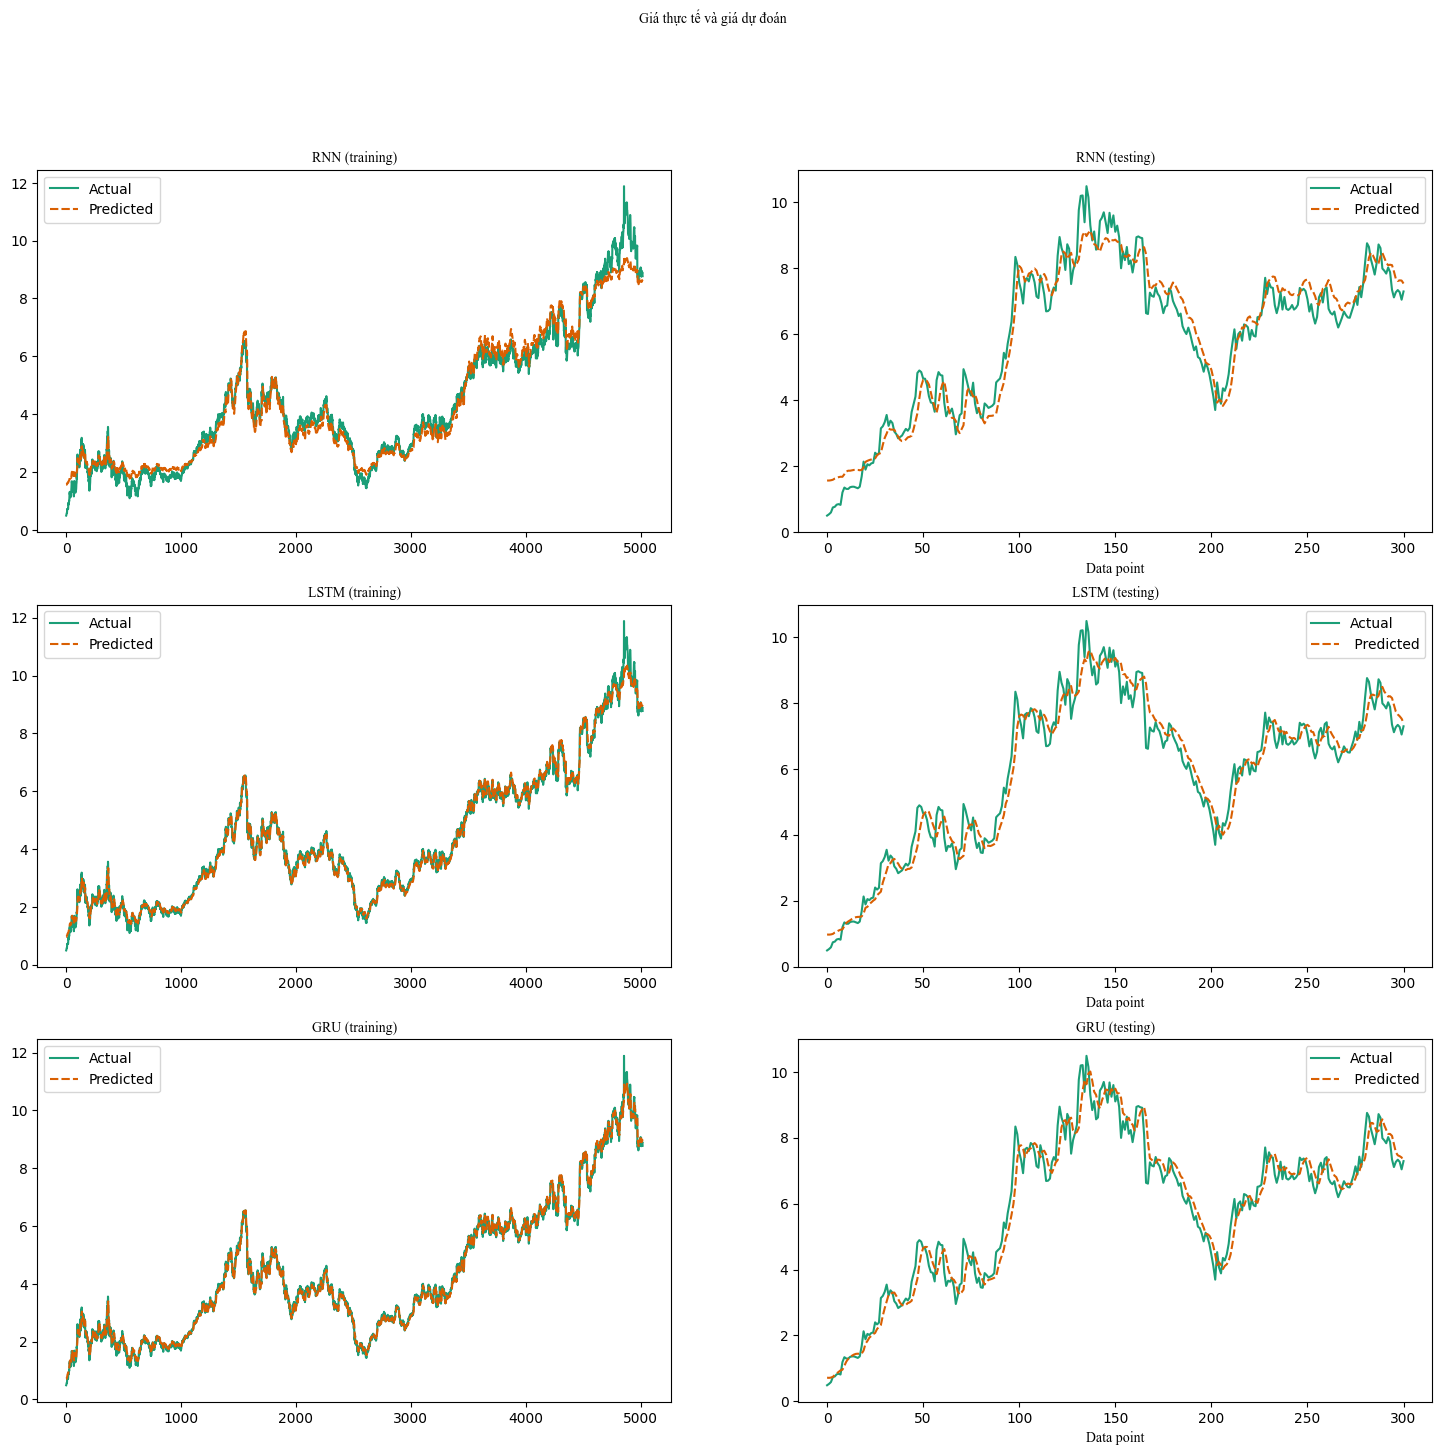

In [49]:
fig, axes = plt.subplots(3, 2, sharex = False, sharey =  False, figsize = (18,16))
fig.suptitle('Giá thực tế và giá dự đoán', fontproperties=times_new_roman)

rnn_training_plot = sns.lineplot(ax = axes[0][0], data = rnn_train_plot)
rnn_training_plot.set_title('RNN (training)', fontproperties=times_new_roman)

rnn_testing_plot = sns.lineplot(ax = axes[0][1], data = rnn_test_plot[0:301])
rnn_testing_plot.set_title('RNN (testing)', fontproperties=times_new_roman)
rnn_testing_plot.set_xlabel('Data point', fontproperties=times_new_roman)

lstm_training_plot = sns.lineplot(ax = axes[1][0], data = lstm_train_plot)
lstm_training_plot.set_title('LSTM (training)', fontproperties=times_new_roman)

lstm_testing_plot = sns.lineplot(ax = axes[1][1], data = lstm_test_plot[0:301])
lstm_testing_plot.set_title('LSTM (testing)', fontproperties=times_new_roman)
lstm_testing_plot.set_xlabel('Data point', fontproperties=times_new_roman)

gru_training_plot = sns.lineplot(ax = axes[2][0], data = gru_train_plot)
gru_training_plot.set_title('GRU (training)', fontproperties=times_new_roman)

gru_testing_plot = sns.lineplot(ax = axes[2][1], data = gru_test_plot[0:301])
gru_testing_plot.set_title('GRU (testing)', fontproperties=times_new_roman)
gru_testing_plot.set_xlabel('Data point', fontproperties=times_new_roman);

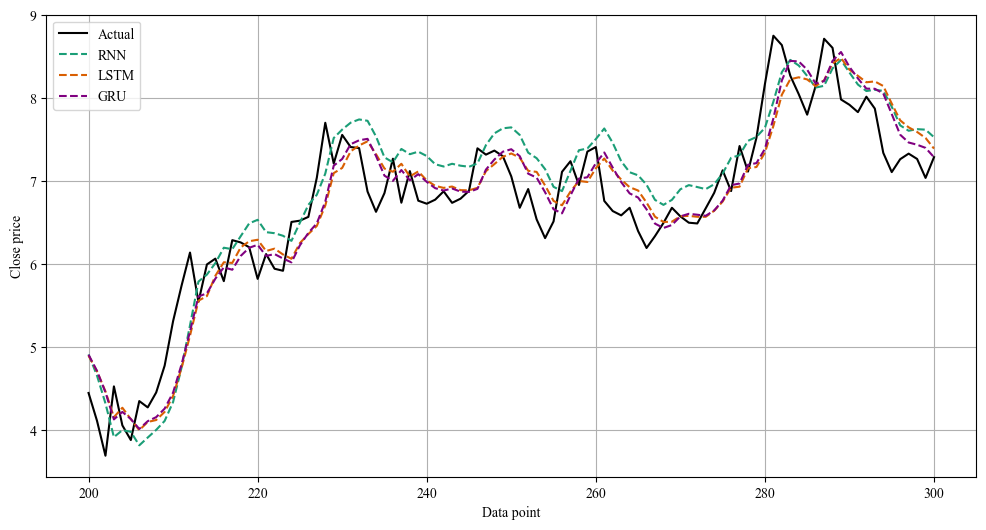

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Lấy ra giá trị thực tế từ một trong các DataFrame (ví dụ: rnn_test_plot)
actual_values = rnn_test_plot[200:301]['Actual']

# Vẽ đường giá trị thực tế
plt.plot(actual_values.index, actual_values, label="Actual", color="black")

# Vẽ đường dự đoán của RNN
plt.plot(rnn_test_plot[200:301].index, rnn_test_plot[200:301][' Predicted'], label="RNN", linestyle="--")

# Vẽ đường dự đoán của LSTM
plt.plot(lstm_test_plot[200:301].index, lstm_test_plot[200:301][' Predicted'], label="LSTM", linestyle="--")

# Vẽ đường dự đoán của GRU
plt.plot(gru_test_plot[200:301].index, gru_test_plot[200:301][' Predicted'], label="GRU", linestyle="--", color = "purple")

# Cấu hình biểu đồ
plt.xlabel('Data point', fontproperties=times_new_roman)
plt.ylabel('Close price', fontproperties=times_new_roman)
plt.legend(prop=times_new_roman)
# Cập nhật font cho các tick labels
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontproperties(times_new_roman)
plt.grid(True)  # Thêm lưới để dễ đọc hơn
plt.savefig('prediction.svg',format='svg')
plt.show()

In [51]:
# %%capture
# !pip install captum

In [52]:
# from captum.attr import IntegratedGradients
# print("\n\nGiải thích mô hình LSTM bằng XAI (Integrated Gradients)")

# lstm_model.eval() # Đảm bảo mô hình ở chế độ đánh giá

# sequence_length = X_train.shape[1] # Độ dài chuỗi đầu vào (ví dụ: 14)
# num_samples_to_explain = 3

# if len(X_test) >= num_samples_to_explain:
#     # Lấy các mẫu từ X_test (đã ở trên device) và đảm bảo requires_grad=True
#     inputs_to_explain = X_test[0:num_samples_to_explain].clone().detach().requires_grad_(True)
#     baselines = torch.zeros_like(inputs_to_explain) # Baseline là tensor zeros, tự động chuyển sang device của inputs_to_explain

#     ig = IntegratedGradients(lstm_model) # Khởi tạo IG
#     attributions, delta = ig.attribute(inputs_to_explain,
#                                        baselines=baselines,
#                                        return_convergence_delta=True)

#     print(f"Convergence Delta (nên gần 0 cho mỗi mẫu): {delta.cpu().detach().numpy()}")
#     attributions_np = attributions.cpu().detach().numpy() # Chuyển về numpy để vẽ

#     for i in range(num_samples_to_explain):
#         sample_attribution = attributions_np[i, :, 0] # Attributions cho mẫu i
#         original_input_sample_scaled = X_test[i, :, 0] # Dữ liệu đầu vào gốc từ X_test (đã scale)

#         fig, axs = plt.subplots(1, 2, figsize=(16, 6)) # Kích thước phù hợp hơn
#         fig.suptitle(f'XAI cho Mẫu {i+1} trên Tập Test', fontsize=16)

#         # Biểu đồ 1: Chuỗi đầu vào gốc (đã scale)
#         axs[0].plot(range(sequence_length), original_input_sample_scaled, marker='o', linestyle='-', color='dodgerblue', label='Chuỗi đầu vào (đã scale)')
#         axs[0].set_title(f'Chuỗi đầu vào gốc ({sequence_length} ngày)', fontsize=12)
#         axs[0].set_xlabel('Bước thời gian (Ngày)', fontsize=11)
#         axs[0].set_ylabel('Giá trị (đã scale)', fontsize=11)
#         axs[0].set_xticks(range(sequence_length))
#         axs[0].tick_params(axis='both', which='major', labelsize=10)
#         # for label_ax in (axs[0].get_xticklabels() + axs[0].get_yticklabels()): # Sửa tên biến
#         #     label_ax.set_fontproperties(times_new_roman_font)
#         axs[0].legend( fontsize=10)
#         axs[0].grid(True, linestyle='--', alpha=0.7)

#         # Biểu đồ 2: Feature Attributions
#         bar_colors = ['forestgreen' if x > 0 else 'firebrick' for x in sample_attribution]
#         axs[1].bar(range(sequence_length), sample_attribution, color=bar_colors, label='Điểm đóng góp')
#         axs[1].set_title(f'Mức độ đóng góp của Feature (Integrated Gradients)', fontsize=12)
#         axs[1].set_xlabel('Bước thời gian trong chuỗi đầu vào (Ngày)', fontsize=11)
#         axs[1].set_ylabel('Điểm đóng góp (Attribution Score)',  fontsize=11)
#         axs[1].set_xticks(range(sequence_length))
#         axs[1].axhline(0, color='black', linewidth=0.8)
#         axs[1].tick_params(axis='both', which='major', labelsize=10)
#         # for label_ax in (axs[1].get_xticklabels() + axs[1].get_yticklabels()): # Sửa tên biến
#         #     label_ax.set_fontproperties(times_new_roman_font)
#         axs[1].legend( fontsize=10)
#         axs[1].grid(True, linestyle='--', alpha=0.7)

#         plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh để tiêu đề chính không bị chồng
#         plt.show()

#         # In thông tin dự đoán và thực tế (đã scale và chưa scale)
#         input_for_pred = X_test[i].unsqueeze(0)
#         predicted_value_scaled = lstm_model(input_for_pred).item()
#         actual_value_scaled = y_test_lstm[i].item() # y_test_lstm đã ở trên device

#         predicted_value_unscaled = scaler.inverse_transform(np.array([[predicted_value_scaled]]))[0,0]
#         actual_value_unscaled = scaler.inverse_transform(np.array([[actual_value_scaled]]))[0,0]

#         print(f"Thông tin giải thích cho mẫu {i+1}:")
#         print(f"  Giá trị đầu vào ({sequence_length} ngày, đã scale): {np.round(original_input_sample_scaled, 4)}")
#         print(f"  Dự đoán (scale): {predicted_value_scaled:.4f} | Thực tế (scale): {actual_value_scaled:.4f}")
#         print(f"  Dự đoán (chưa scale): {predicted_value_unscaled:.2f} | Thực tế (chưa scale): {actual_value_unscaled:.2f}")
#         print(f"  Điểm đóng góp của từng ngày đầu vào (attributions): {np.round(sample_attribution, 4)}")
#         print("-" * 60)
# else:
#     print("Không đủ mẫu trong X_test để thực hiện giải thích XAI.")

In [53]:
!pip install shap

In [54]:
sequence_length = X_train.shape[1] # Độ dài chuỗi đầu vào (ví dụ: 14)



Explaining GRU Models Using XAI (SHAP)
Size of SHAP values: (3, 14, 1, 1)

--- Additivity Check for Sample 1 ---
Sum of SHAP values: -0.234877
Model output difference (output - expected): -0.236462
Difference (Sum SHAP - Output Diff): 0.001585
------------------------------


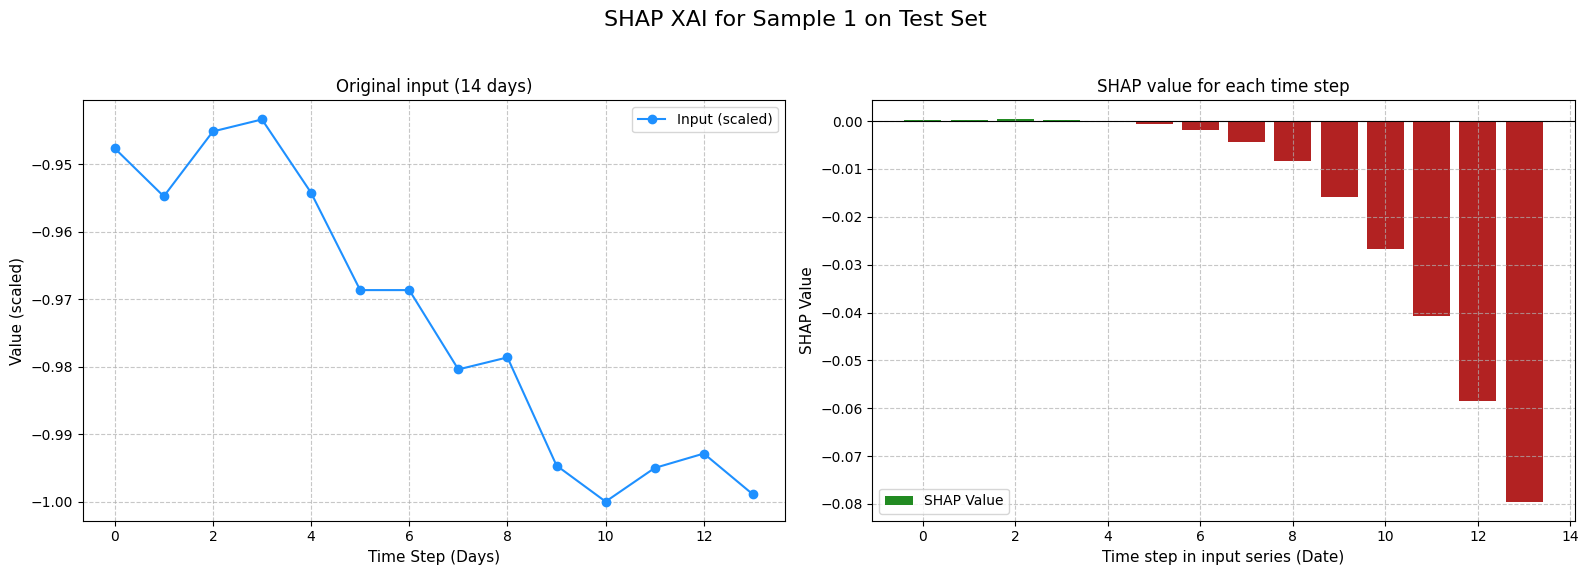

SHAP information for the sample 1:
  Predicted values (scaled): -0.9598 | True values (scale): -1.0000
  SHAP value of each input date: [ 0.0002  0.0003  0.0003  0.0003  0.0001 -0.0005 -0.0018 -0.0043 -0.0083
 -0.0158 -0.0267 -0.0408 -0.0584 -0.0795]
------------------------------------------------------------

--- Additivity Check for Sample 2 ---
Sum of SHAP values: -0.238163
Model output difference (output - expected): -0.237324
Difference (Sum SHAP - Output Diff): -0.000840
------------------------------


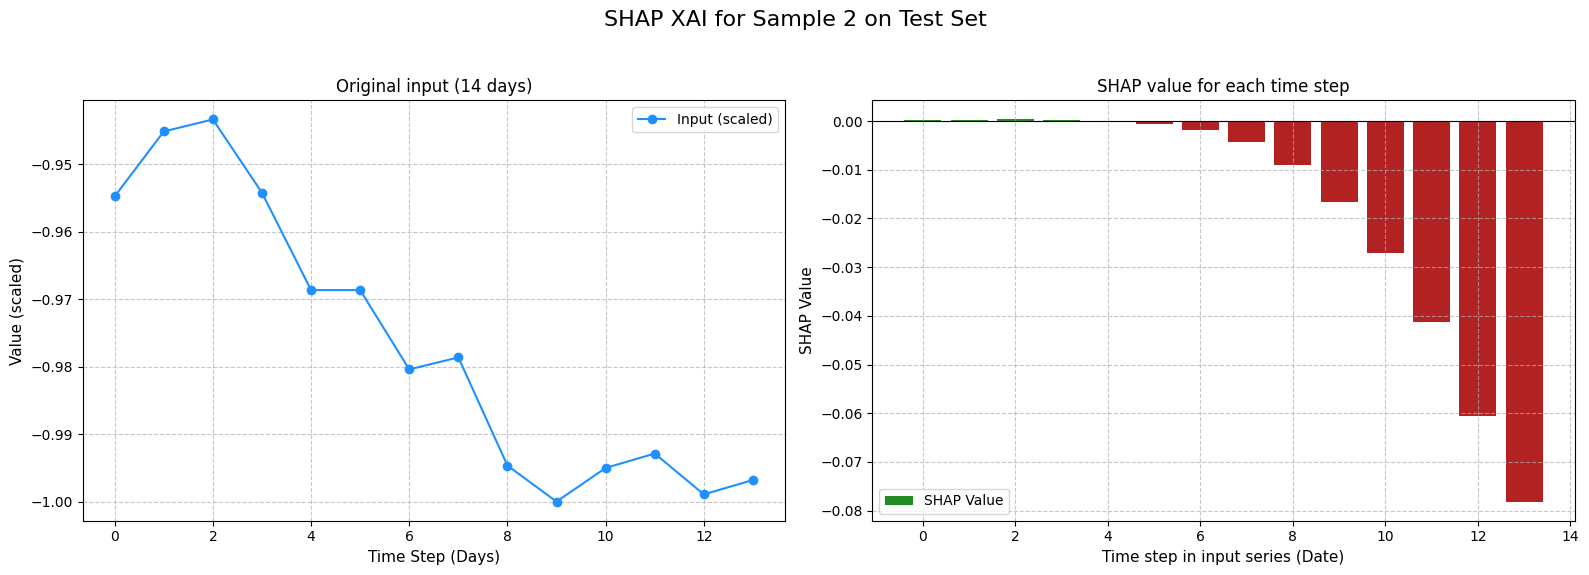

SHAP information for the sample 2:
  Predicted values (scaled): -0.9606 | True values (scale): -0.9929
  SHAP value of each input date: [ 0.0002  0.0003  0.0003  0.0003  0.0001 -0.0005 -0.0019 -0.0044 -0.0091
 -0.0166 -0.027  -0.0413 -0.0605 -0.0781]
------------------------------------------------------------

--- Additivity Check for Sample 3 ---
Sum of SHAP values: -0.244016
Model output difference (output - expected): -0.235911
Difference (Sum SHAP - Output Diff): -0.008105
------------------------------


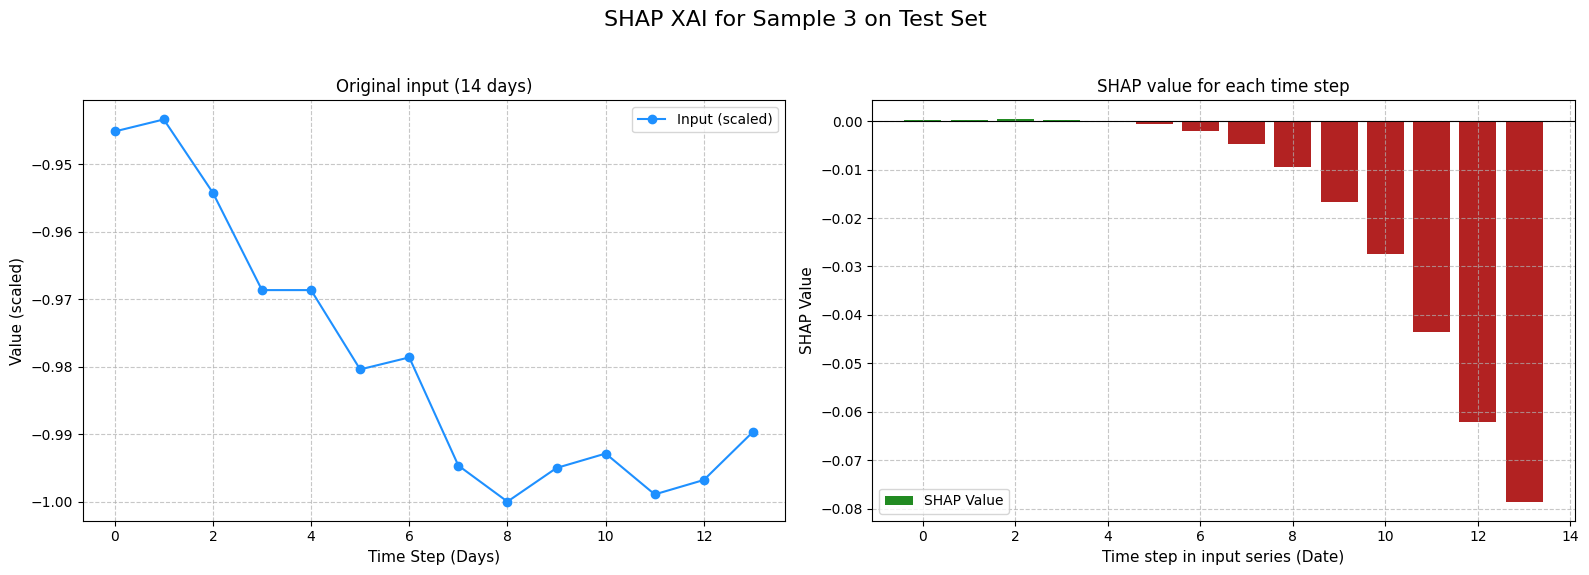

SHAP information for the sample 3:
  Predicted values (scaled): -0.9592 | True values (scale): -0.9832
  SHAP value of each input date: [ 0.0002  0.0003  0.0004  0.0003  0.0001 -0.0006 -0.0019 -0.0048 -0.0095
 -0.0168 -0.0275 -0.0436 -0.0622 -0.0786]
------------------------------------------------------------


In [59]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# Giả sử gru_model, X_train, X_test, sequence_length đã được định nghĩa như trong script của bạn
# và đã ở trên device phù hợp (ví dụ: 'cuda' hoặc 'cpu')

print("\n\nExplaining GRU Models Using XAI (SHAP)")
gru_model.eval() # Đảm bảo mô hình ở chế độ đánh giá

# 1. Chọn một tập dữ liệu nền (background dataset) từ X_train
# Số lượng mẫu nền thường từ vài chục đến vài trăm
num_background_samples = min(500, X_train.shape[0])
background_data = X_train[:num_background_samples].clone().detach()

# 2. Khởi tạo GradientExplainer
# GradientExplainer mong đợi mô hình và dữ liệu nền làm đầu vào
explainer_shap = shap.GradientExplainer(gru_model, background_data)

# 3. Lấy các mẫu từ X_test để giải thích
num_samples_to_explain = 3
if len(X_test) >= num_samples_to_explain:
    inputs_to_explain_shap = X_test[0:num_samples_to_explain].clone().detach()

    # 4. Tính toán giá trị SHAP
    try:
        shap_values = explainer_shap.shap_values(inputs_to_explain_shap)

        print(f"Size of SHAP values: {shap_values.shape}")

        # Calculate expected value from background data
        with torch.no_grad():
            background_outputs = gru_model(background_data)
            expected_value = background_outputs.mean(dim=0).cpu().numpy() # Assuming single output neuron

        # Calculate model output for inputs to explain
        with torch.no_grad():
             model_outputs = gru_model(inputs_to_explain_shap).cpu().numpy()

        # 5. Trực quan hóa (tương tự như Integrated Gradients)
        for i in range(num_samples_to_explain):
            # Correct the shape of sample_shap_values to be 1-dimensional
            sample_shap_values = shap_values[i, :, 0].reshape(-1) # SHAP values cho mẫu i, đặc trưng đầu tiên

            original_input_sample_scaled = X_test[i, :, 0].cpu().numpy() # Dữ liệu gốc (đã scale)

            # Manually check additivity
            sum_of_shap_values = sample_shap_values.sum()
            output_difference = model_outputs[i, 0] - expected_value[0] # Assuming single output neuron

            print(f"\n--- Additivity Check for Sample {i+1} ---")
            print(f"Sum of SHAP values: {sum_of_shap_values:.6f}")
            print(f"Model output difference (output - expected): {output_difference:.6f}")
            print(f"Difference (Sum SHAP - Output Diff): {(sum_of_shap_values - output_difference):.6f}")
            print("-" * 30)

            fig, axs = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'SHAP XAI for Sample {i+1} on Test Set', fontsize=16)

            # Biểu đồ 1: Chuỗi đầu vào gốc
            axs[0].plot(range(sequence_length), original_input_sample_scaled, marker='o', linestyle='-', color='dodgerblue', label='Input (scaled)')
            axs[0].set_title(f'Original input ({sequence_length} days)', fontsize=12)
            axs[0].set_xlabel('Time Step (Days)', fontsize=11)
            axs[0].set_ylabel('Value (scaled)', fontsize=11)
            axs[0].grid(True, linestyle='--', alpha=0.7)
            axs[0].legend(fontsize=10)

            # Biểu đồ 2: SHAP Values
            bar_colors = ['forestgreen' if x > 0 else 'firebrick' for x in sample_shap_values]
            axs[1].bar(range(sequence_length), sample_shap_values, color=bar_colors, label='SHAP Value')
            axs[1].set_title(f'SHAP value for each time step', fontsize=12)
            axs[1].set_xlabel('Time step in input series (Date)', fontsize=11)
            axs[1].set_ylabel('SHAP Value', fontsize=11)
            axs[1].axhline(0, color='black', linewidth=0.8)
            axs[1].grid(True, linestyle='--', alpha=0.7)
            axs[1].legend(fontsize=10)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

            # In thông tin (tương tự script của bạn)
            input_for_pred_shap = X_test[i].unsqueeze(0)
            predicted_value_scaled_shap = gru_model(input_for_pred_shap).item()
            actual_value_scaled_shap = y_test_lstm[i].item()
            # (Thêm phần unscale nếu cần)
            print(f"SHAP information for the sample {i+1}:")
            print(f"  Predicted values (scaled): {predicted_value_scaled_shap:.4f} | True values (scale): {actual_value_scaled_shap:.4f}")
            print(f"  SHAP value of each input date: {np.round(sample_shap_values, 4)}")
            print("-" * 60)

    except AssertionError as e:
        print(f"SHAP Assertion Error caught: {e}")
        # You can choose to pass or handle the error here.
        # Printing the error and continuing might be useful for debugging other samples.
        pass # Or raise e if you want the execution to stop

In [56]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=99e509a163a1babf2e0ecb6483f664fdf1b8f264053597e1b2eec3e9d6c10a09
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime




Explain LSTM model using XAI (LIME)

Explain LIME for pattern 1...
  LIME weights (feature, weight):
    Day 1 <= -0.64: 0.0023
    Day 2 <= -0.64: -0.0040
    Day 3 <= -0.64: -0.0018
    Day 4 <= -0.64: -0.0065
    Day 5 <= -0.64: -0.0045
    Day 6 <= -0.64: -0.0123
    Day 7 <= -0.64: -0.0027
    Day 8 <= -0.64: -0.0128
    Day 9 <= -0.64: -0.0197
    Day 10 <= -0.64: -0.0478
    Day 11 <= -0.64: -0.0635
    Day 12 <= -0.64: -0.0974
    Day 13 <= -0.64: -0.1558
    Day 14 <= -0.64: -0.2281


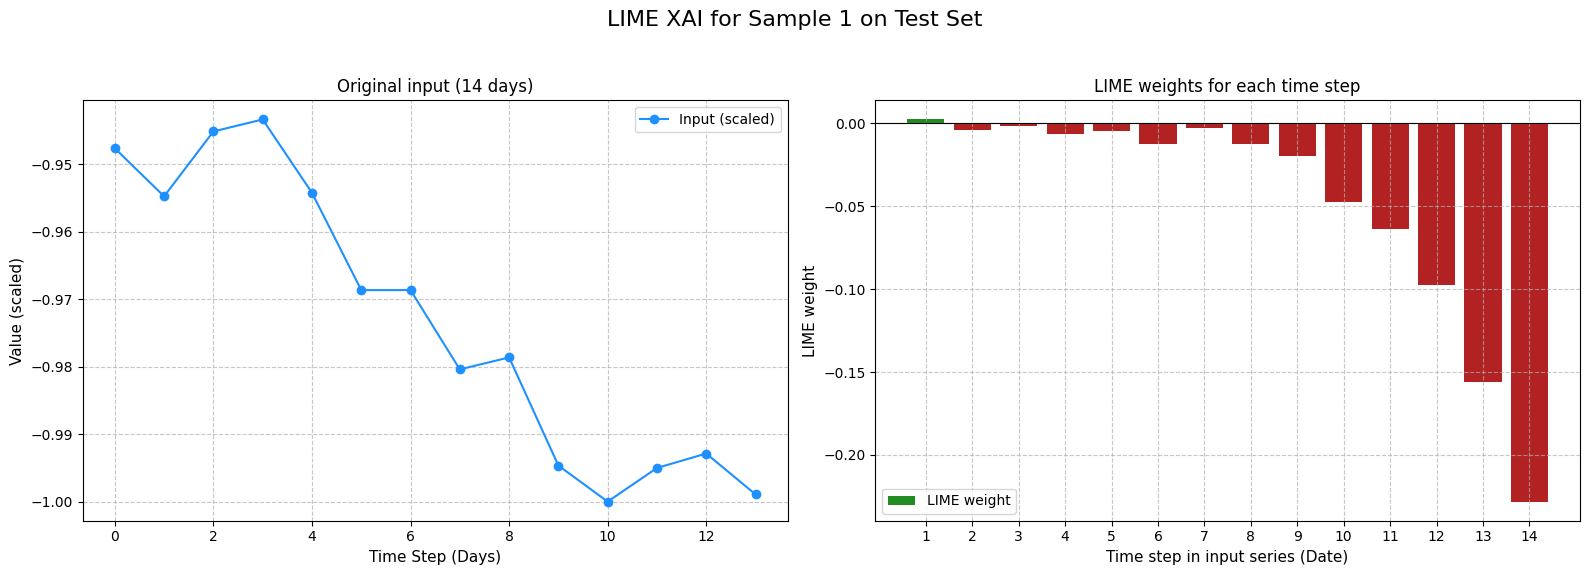

LIME information for sample 1:
  Predicted values (scaled): -0.9598 | True values (scale): -1.0000
  LIME weight of each input day: [ 0.0023 -0.004  -0.0018 -0.0065 -0.0045 -0.0123 -0.0027 -0.0128 -0.0197
 -0.0478 -0.0635 -0.0974 -0.1558 -0.2281]
------------------------------------------------------------

Explain LIME for pattern 2...
  LIME weights (feature, weight):
    Day 1 <= -0.64: 0.0037
    Day 2 <= -0.64: -0.0008
    Day 3 <= -0.64: 0.0021
    Day 4 <= -0.64: -0.0067
    Day 5 <= -0.64: -0.0067
    Day 6 <= -0.64: -0.0023
    Day 7 <= -0.64: 0.0013
    Day 8 <= -0.64: -0.0051
    Day 9 <= -0.64: -0.0245
    Day 10 <= -0.64: -0.0348
    Day 11 <= -0.64: -0.0605
    Day 12 <= -0.64: -0.1068
    Day 13 <= -0.64: -0.1581
    Day 14 <= -0.64: -0.2223


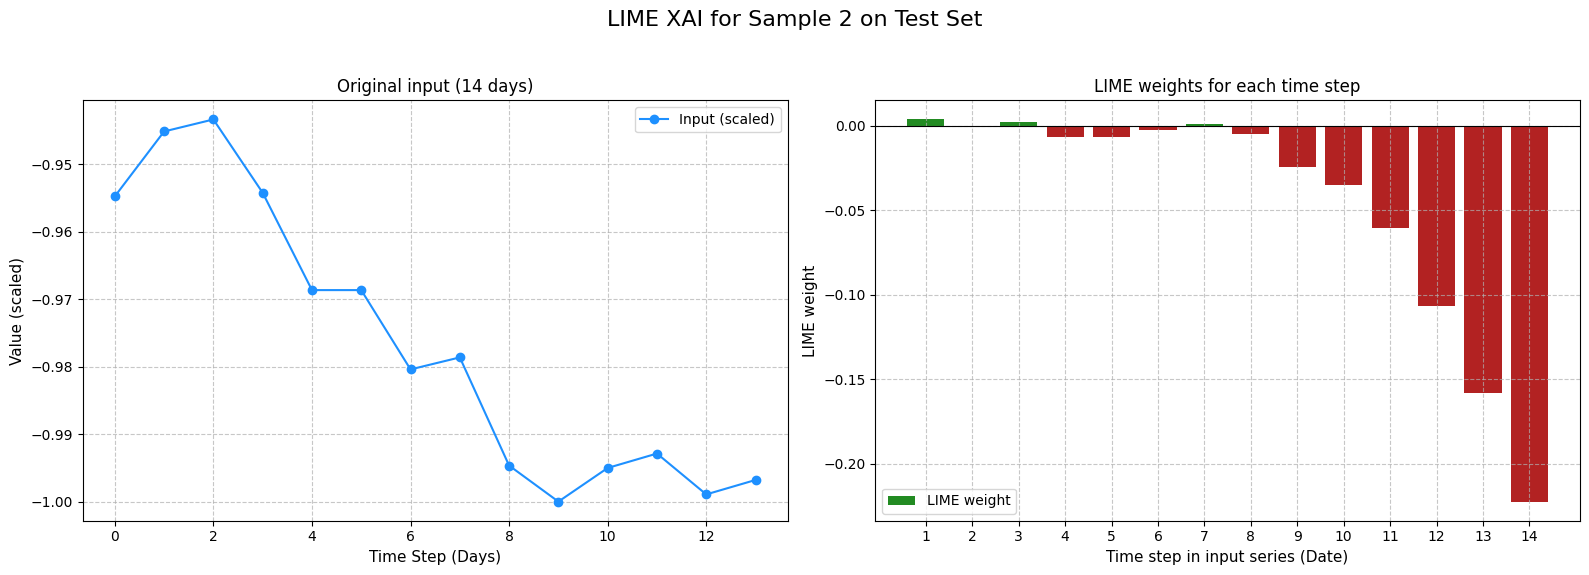

LIME information for sample 2:
  Predicted values (scaled): -0.9606 | True values (scale): -0.9929
  LIME weight of each input day: [ 0.0037 -0.0008  0.0021 -0.0067 -0.0067 -0.0023  0.0013 -0.0051 -0.0245
 -0.0348 -0.0605 -0.1068 -0.1581 -0.2223]
------------------------------------------------------------

Explain LIME for pattern 3...
  LIME weights (feature, weight):
    Day 1 <= -0.64: 0.0103
    Day 2 <= -0.64: 0.0043
    Day 3 <= -0.64: -0.0039
    Day 4 <= -0.64: 0.0035
    Day 5 <= -0.64: 0.0070
    Day 6 <= -0.64: 0.0004
    Day 7 <= -0.64: 0.0037
    Day 8 <= -0.64: -0.0155
    Day 9 <= -0.64: -0.0143
    Day 10 <= -0.64: -0.0269
    Day 11 <= -0.64: -0.0604
    Day 12 <= -0.64: -0.1088
    Day 13 <= -0.64: -0.1523
    Day 14 <= -0.64: -0.2243


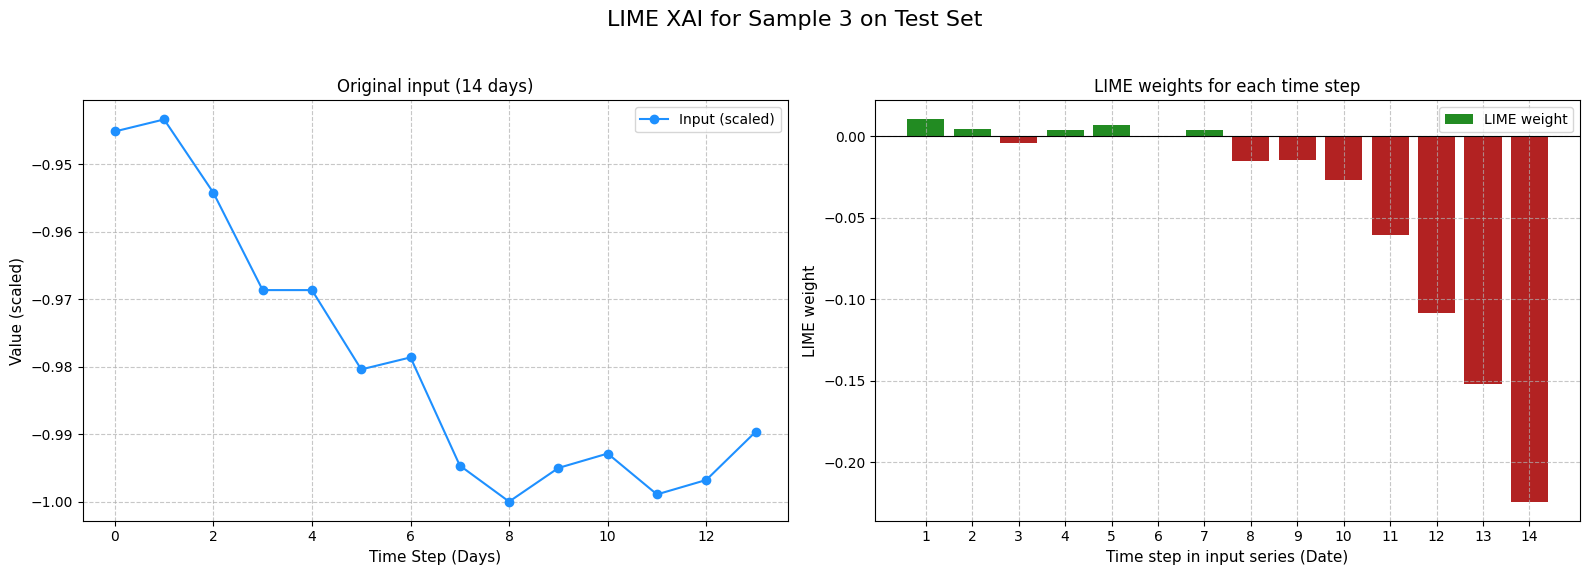

LIME information for sample 3:
  Predicted values (scaled): -0.9592 | True values (scale): -0.9832
  LIME weight of each input day: [ 0.0103  0.0043 -0.0039  0.0035  0.007   0.0004  0.0037 -0.0155 -0.0143
 -0.0269 -0.0604 -0.1088 -0.1523 -0.2243]
------------------------------------------------------------


In [58]:
import lime
import lime.lime_tabular
import torch
import numpy as np
import matplotlib.pyplot as plt

# Giả sử gru_model, X_train, X_test, sequence_length, scaler đã được định nghĩa
# và X_train, X_test là tensor trên device.

print("\n\nExplain LSTM model using XAI (LIME)")
gru_model.eval()

# 1. Định nghĩa hàm dự đoán cho LIME
# Hàm này nhận đầu vào là một NumPy array (số mẫu, số đặc trưng đã flatten)
# và trả về dự đoán của mô hình (NumPy array)
def predict_fn_lime(numpy_data):
    # numpy_data có shape (num_samples, sequence_length * num_features_per_step)
    # hoặc (num_samples, sequence_length) nếu num_features_per_step = 1

    # Chuyển sang Tensor PyTorch, lên device, và reshape
    # Giả sử num_features_per_step là 1 dựa trên script gốc
    num_features_per_step = 1 # Hoặc X_train.shape[2]

    # Kiểm tra xem dữ liệu đầu vào có cần reshape không dựa trên cách LIME tạo ra
    # Nếu LIME đang làm việc với từng điểm thời gian như một đặc trưng,
    # numpy_data sẽ có shape (num_perturbations, sequence_length)

    # Chuyển về dạng (num_perturbations, sequence_length, num_features_per_step)
    tensor_data = torch.from_numpy(numpy_data).float().to(X_train.device)
    if len(tensor_data.shape) == 2: # (num_perturbations, sequence_length)
        tensor_data = tensor_data.unsqueeze(2) # Thêm chiều feature nếu cần

    with torch.no_grad():
        predictions = gru_model(tensor_data)
    # LIME thường mong đợi output cho regression có shape (num_samples,)
    return predictions.squeeze().cpu().numpy()


# 2. Chuẩn bị dữ liệu huấn luyện cho LIME (dưới dạng NumPy array)
# LIME Tabular Explainer cần dữ liệu này để tính toán mean/std cho việc tạo mẫu lân cận
# và cũng để biết số lượng đặc trưng.
# Nếu mỗi bước thời gian là một đặc trưng:
training_data_lime = X_train[:, :, 0].cpu().detach().numpy() # Shape: (num_train_samples, sequence_length)

# 3. Khởi tạo LimeTabularExplainer
# feature_names có thể là ['Day 1', 'Day 2', ..., 'Day N']
feature_names = [f'Day {j+1}' for j in range(sequence_length)]

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=training_data_lime,
    feature_names=feature_names,
    class_names=['Predicted Price'],
    mode='regression',
    verbose=False
)

# 4. Lấy mẫu để giải thích và thực hiện giải thích
num_samples_to_explain = 3
if len(X_test) >= num_samples_to_explain:
    for i in range(num_samples_to_explain):
        # Lấy một mẫu từ X_test (dưới dạng NumPy array 1D)
        # LIME thường làm việc với từng điểm thời gian như một feature riêng lẻ
        instance_to_explain_lime = X_test[i, :, 0].cpu().detach().numpy() # Shape: (sequence_length,)

        print(f"\nExplain LIME for pattern {i+1}...")
        # Giải thích cho instance này
        # num_features là số lượng đặc trưng quan trọng nhất bạn muốn LIME hiển thị
        explanation_lime = explainer_lime.explain_instance(
            data_row=instance_to_explain_lime,
            predict_fn=predict_fn_lime,
            num_features=sequence_length # Hiển thị tất cả các bước thời gian
        )

        # Lấy ra các trọng số (mức độ quan trọng)
        lime_weights = sorted(explanation_lime.as_list(), key=lambda x: int(x[0].split(' ')[1])) # Sắp xếp theo ngày

        sample_lime_attributions = np.zeros(sequence_length)
        feature_indices_from_lime = []

        print(f"  LIME weights (feature, weight):")
        for feature_str, weight in lime_weights:
            try:
                # Trích xuất chỉ số ngày từ tên đặc trưng, ví dụ "Day 5" -> index 4
                day_index = int(feature_str.split(' ')[1]) - 1
                if 0 <= day_index < sequence_length:
                    sample_lime_attributions[day_index] = weight
                    feature_indices_from_lime.append(day_index)
                print(f"    {feature_str}: {weight:.4f}")
            except (ValueError, IndexError) as e:
                print(f"    Unable to parse feature from LIME: {feature_str} ({e})")

        # 5. Trực quan hóa (tương tự)
        original_input_sample_scaled = instance_to_explain_lime

        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'LIME XAI for Sample {i+1} on Test Set', fontsize=16)

        axs[0].plot(range(sequence_length), original_input_sample_scaled, marker='o', linestyle='-', color='dodgerblue', label='Input (scaled)')
        axs[0].set_title(f'Original input ({sequence_length} days)', fontsize=12)
        axs[0].set_xlabel('Time Step (Days)', fontsize=11)
        axs[0].set_ylabel('Value (scaled)', fontsize=11)
        axs[0].grid(True, linestyle='--', alpha=0.7)
        axs[0].legend(fontsize=10)

        bar_colors_lime = ['forestgreen' if x > 0 else 'firebrick' for x in sample_lime_attributions]
        axs[1].bar(range(sequence_length), sample_lime_attributions, color=bar_colors_lime, label='LIME weight')
        axs[1].set_title(f'LIME weights for each time step', fontsize=12)
        axs[1].set_xlabel('Time step in input series (Date)', fontsize=11)
        axs[1].set_ylabel('LIME weight', fontsize=11)
        axs[1].axhline(0, color='black', linewidth=0.8)
        axs[1].set_xticks(range(sequence_length)) # Đảm bảo hiển thị đủ các ngày
        axs[1].set_xticklabels([f'{j+1}' for j in range(sequence_length)]) # Nhãn cho các ngày
        axs[1].grid(True, linestyle='--', alpha=0.7)
        axs[1].legend(fontsize=10)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # In thông tin (tương tự script của bạn)
        input_for_pred_lime = X_test[i].unsqueeze(0)
        predicted_value_scaled_lime = gru_model(input_for_pred_lime).item()
        actual_value_scaled_lime = y_test_lstm[i].item()
        # (Thêm phần unscale nếu cần)
        print(f"LIME information for sample {i+1}:")
        print(f"  Predicted values (scaled): {predicted_value_scaled_lime:.4f} | True values (scale): {actual_value_scaled_lime:.4f}")
        print(f"  LIME weight of each input day: {np.round(sample_lime_attributions, 4)}")
        print("-" * 60)